<a href="https://colab.research.google.com/github/ewilli400/Exam-2/blob/main/Copy_of_5_1_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.1 Linear Regression

In 1991, Orley Ashenfelter, an economics professor at Princeton University, stunned the wine world with a bold prediction. He predicted that the 1990 vintage of Bordeaux wines would be the "wine of the century,'' even better than the prized 1961 vintage. Furthermore, he made this prediction without tasting even a drop of the wine, which had been placed in oak barrels just months earlier.

How did Ashenfelter predict the quality of the wine without tasting it? He used data on past vintages to come up with the following formula for predicting wine quality:

\begin{align}
    \widehat{\text{wine quality}} = -7.8 &+ 0.62 \cdot (\text{average summer temperature}) \nonumber \\
    &+ 0.0012 \cdot (\text{winter rainfall}) \nonumber \\
    &- 0.0037 \cdot (\text{harvest rainfall}) \nonumber \\
    &+ 0.024 \cdot (\text{age of the wine})
    \label{eq:ashenfelter}
\end{align}

The variable on the left-hand side of this expression, wine quality, is what we are trying to predict and is called 
the _target_ (or _label_). (The hat symbol over  "wine quality" indicates that the values are predicted instead of observed.) The variables on the right-hand side, such as "average summer temperature" and "harvest rainfall," are called _features_ and are the inputs used to predict the target. Although Ashenfelter had no way of knowing the quality of the 1990 wines, he did have the values of the features in 1990, so to make a prediction, all he had to do was plug those values into the equation above. In this way, he arrived at the following prediction for the quality of the 1990 Bordeaux, after they had been aged for 31 years (like the 1961 Bordeaux had been at the time):

\begin{align}
    -7.8 &+ 0.62 \cdot (18.7) \nonumber \\
    &+ 0.0012 \cdot (468) \nonumber \\
    &- 0.0037 \cdot (80) \nonumber \\
    &+ 0.024 \cdot (31) = 4.8.  \label{eq:ashenfelter_1990}
\end{align}

For comparison, the quality of the prized 1961 vintage was 4.6.

You can imagine the uproar from wine experts, who had spent years refining their palates to distinguish good wines from bad. Robert Parker, the most influential wine critic in America, called Ashenfelter's predictions "ludicrous and absurd", comparing him to a "movie critic who never goes to see the movie but tells you how good it is based on the actors and the director." It did not help that Ashenfelter had also openly challenged Parker's rating of the 1986 Bordeaux. Parker thought they would be "very good and sometimes exceptional." But according to Ashenfelter's formula, the low summer temperatures and high harvest rainfalls in 1986 doomed the vintage.

Who was right? Thirty years later, Robert Parker ranks the 1986 Bordeaux well, but the 1990 Bordeaux wines are exceptional, with three of the six wines scoring a 98 on a 100-point scale.

In this lesson, we will reproduce Ashenfelter's analysis, which is an example of _machine learning_. Machine learning is concerned with the general problem of how to use data to make predictions. The process of producing a model like Ashenfelter's from data is called _fitting_ a model (although the terms _training_ or _learning_ are also used), and the data that is used to fit the model is the
_training data_.

## Getting Familiar with the Data

First, we read in the historical data that Ashenfelter used. The observational unit in this data set is the vintage, so we index this `DataFrame` by the year.

In [ ]:
import pandas as pd
data_dir = "https://dlsun.github.io/pods/data/"
bordeaux_df = pd.read_csv(data_dir + "bordeaux.csv",
                          index_col="year")
bordeaux_df.head()

,price,summer,har,sep,win,age
year,,,,,,
1952,37.0,17.1,160,14.3,600,40
1953,63.0,16.7,80,17.3,690,39
1955,45.0,17.1,130,16.8,502,37
1957,22.0,16.1,110,16.2,420,35
1958,18.0,16.4,187,19.1,582,34


The **price** column is in 1981 dollars, normalized so that the 1961 Bordeaux has a price of 100. Price is a reasonable proxy for the quality of the wine. The **summer** column contains the average summer temperature (in degrees Celsius), while the **har** and **win** columns contain the harvest and winter rainfalls (in millimeters). The **sep** column stores the average temperature in September, which Ashenfelter did not include in his model.

Let us also take a peek at the end of this `DataFrame`.

In [ ]:
bordeaux_df.tail()

,price,summer,har,sep,win,age
year,,,,,,
1987,NaN,17.0,115,18.9,452,5
1988,NaN,17.1,59,16.8,808,4
1989,NaN,18.6,82,18.4,443,3
1990,NaN,18.7,80,19.3,468,2
1991,NaN,17.7,183,20.4,570,1


We see that the `DataFrame` also contains data for vintages where the price is missing (including 1990, the vintage for which Ashenfelter made his prediction). In fact, prices are only available up to 1980, as it takes several years before wine quality can be estimated with much reliability), so only part of the `DataFrame` can be used for training. The rest of the data, where the features are known but the target is not, is called the _test data_. Machine learning fits a model to the training data, which is then used to predict the targets in the test data. The following code splits the `DataFrame` into the training and test sets.

In [ ]:
bordeaux_train = bordeaux_df.loc[:1980].copy()
bordeaux_test = bordeaux_df.loc[1981:].copy()

## Warm-Up: A Model with One Feature

Before fitting a model that uses all of the features, we first consider a model that uses only the age of the wine to predict the price. That is, we fit a model of the form
\begin{equation}
    \widehat{\text{price}} = b + c \cdot \text{age},
    \label{eq:simple_linear_regression}
\end{equation}
where $b$ and $c$ are numbers that we will learn from the training data. Models of the form above are called _linear regression_ models. (The way in which this model is "linear" will become apparent in a moment.) This model only involves two variables, **age** and **price**, so we can visualize the data easily using a scatterplot (see Chapter 3).

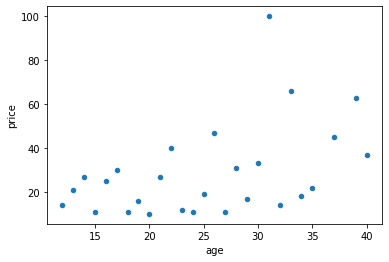

In [ ]:
bordeaux_train.plot.scatter(x="age", y="price")

Now, to fit models like the above to the training data, we use the scikit-learn package, which was used in Chapter 3 for transforming variables and calculating distances. However, its main purpose is to fit machine learning models, including linear regression. All models in scikit-learn are used in essentially the same way, following the three-step pattern:

1. Declare the model.
2. Fit the model to training data.
3. Use the model to predict on test data.

In the case of the linear regression model above, the code is as follows.

In [ ]:
from sklearn.linear_model import LinearRegression

X_train = bordeaux_train[["age"]]
X_test = bordeaux_test[["age"]]
y_train = bordeaux_train["price"]

model = LinearRegression()
model.fit(X=X_train, y=y_train)
model.predict(X=X_test)

array([12.41648163, 11.26046336, 10.1044451 ,  8.94842683,  7.79240856,
        6.6363903 ,  5.48037203,  4.32435376,  3.1683355 ,  2.01231723,
        0.85629897])

The parameters of `.fit()` are `X` for the features and `y` for the targets, which are assumed to be 2-D and 1-D arrays of numbers, respectively. So even when there is only one feature, as in this case, we still need to supply a 2-D array with one column---hence, the double brackets around `"age"` when defining `X_train` and `X_test`.

By contrast, `.predict()` only has one parameter, `X` for the features. That is because its job is to predict the targets `y` for the given features. Note that the predictions will always be returned in the form of `numpy` arrays, no matter the type of the input data---so although we supplied `pandas` objects, `sklearn` still returned the predicted values as `numpy` arrays. The predictions are in the same order as the rows of `X`.

Because there are only two variables involved, the model above is a rare example of a machine learning model we can visualize. A general way to do this is to generate a fine grid of `X` values using `np.linspace()` and call `model.predict()` to get the predicted target at each of these values. We can then use these predictions to draw a curve which depicts the predicted value of `y` at each value of `X`. In the code below, we put the predictions in a `pandas` `Series`, indexed by the `X` values, and then call `.plot.line()`.

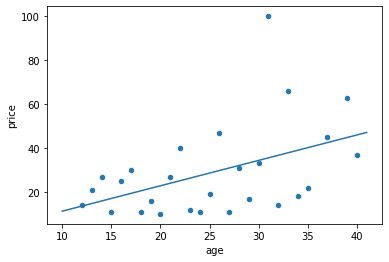

In [ ]:
import numpy as np

X_new = pd.DataFrame()
# create a sequence of 200 evenly spaced numbers from 10 to 41
X_new["age"] = np.linspace(10, 41, num=200)

# create a Series out of the predicted values
# (trailing underscore indicates fitted values)
y_new_ = pd.Series(
    model.predict(X_new), # y values in Series.plot.line()
    index=X_new["age"]    # x values in Series.plot.line()
)

# plot the data, then the model
bordeaux_train.plot.scatter(x="age", y="price")
y_new_.plot.line()

The resulting plot is shown above. Notice that the curve is a straight line, which is why this model is called  _linear_ regression. In hindsight, this is obvious from the model equation: $b$ is simply the intercept and $c$ the slope of this line. All linear regression does is choose the intercept and slope to minimize the total squared distance between the points and the line---that is, between the observed and predicted prices. In mathematical terms, $b$ and $c$ are chosen to minimize
\begin{align}
    & \text{sum of } (\text{price} - \widehat{\text{price}})^2 &= & & \text{sum of } (\text{price} - (b + c\cdot \text{age}))^2 \\
    & \text{over training data } &\phantom{=} & & \text{ over training data}.
\end{align}
Since `sklearn` does this optimization for us, it is not necessary to understand the details of this process to extract useful insights out of linear regression. However, the math is explained in the appendix of this lesson for those who are curious.

## What to Do about Nonlinearity

One question is whether the relationship between age and price is truly linear. In the graph above, it seems that the points deviate more from the line when prices are high than when they are low. To correct this, we need to spread out low prices and rein in high prices. In Chapter 3, we learned that this can be achieved by applying a log transformation to the prices. Let's add a column to the training data for the log-price.

In [ ]:
bordeaux_train["log(price)"] = np.log(bordeaux_train["price"])

Now, we will fit a linear regression model to predict this new target. That is, in contrast to the previous model, we now fit the model 
\begin{equation}
    \widehat{\text{log(price)}} = b + c \cdot \text{age},
    \label{eq:simple_linear_regression_log}
\end{equation}
where $b$ and $c$ are chosen to minimize 
\begin{equation}
    \text{sum of } (\text{log(price)} - \widehat{\text{log(price)}})^2 \text{ over training data}
\end{equation}
over the training data. The code below fits this model.

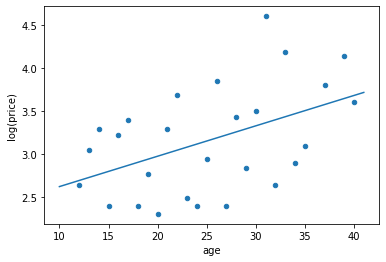

In [ ]:
log_price_model = LinearRegression()
log_price_model.fit(X=bordeaux_train[["age"]],
                    y=bordeaux_train["log(price)"])

X_new = pd.DataFrame()
X_new["age"] = np.linspace(10, 41, num=200)
y_new_ = pd.Series(
    log_price_model.predict(X_new),
    index=X_new["age"]
)
    
bordeaux_train.plot.scatter(x="age", y="log(price)")
y_new_.plot.line()

The points are more evenly spread out when the target is log-price instead of price. For this reason, Ashenfelter chose log-price to be the measure of "wine quality" in his linear regression model.

## Fitting Ashenfelter's Model

We are now ready to reproduce Ashenfelter's analysis. To do so, we will need to fit a linear regression model that predicts the log-price from the average summer temperature, winter rainfall, harvest rainfall, and the age of the wine. In other words, the model is of the form
\begin{align}
    \widehat{\text{log(price)}} = b &+ c_1 \cdot (\text{average summer temperature}) \nonumber \\
    &+ c_2 \cdot (\text{winter rainfall}) \nonumber \\
    &+ c_3 \cdot (\text{harvest rainfall}) \nonumber \\
    &+ c_4 \cdot (\text{age of the wine}), \label{eq:multiple_linear_regression}
\end{align}
where $b, c_1, c_2, c_3, c_4$ are chosen to minimize 
\begin{equation}
    \text{sum of } (\text{log(price)} - \widehat{\text{log(price)}})^2 \text{ over training data.}
\end{equation}
This is still a _linear regression_ model, albeit a more complicated one.

The code to fit this model is the natural extension of the code we wrote to fit the earlier models in this lesson. Instead of passing `bordeaux_train[["age"]]` for `X`, we now supply a `DataFrame` containing all of the features we want to be in the model.

In [ ]:
ashen_model = LinearRegression()
ashen_model.fit(
    X=bordeaux_train[["summer", "win", "har", "age"]],
    y=bordeaux_train["log(price)"]
)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

This model is much harder to visualize, since it involves five variables: four features, plus the target. Nevertheless, we can obtain predictions from it just as we did with the simpler models above. We just need to supply the values of all of the features in the model, in the same order as in the training data.

In [ ]:
ashen_model.predict(
    X=bordeaux_test[["summer", "win", "har", "age"]]
)

array([3.17926885, 3.4231464 , 3.71919787, 2.83391541, 3.48195778,
       2.4330387 , 2.91879638, 3.5924235 , 3.97294747, 4.04789338,
       3.14087609])

## Communication Corner: Interpreting the Model

Even though we cannot visualize Ashenfelter's model, we can still 
interpret the model by examining the values of the _intercept_ $b$ and the _coefficients_ $c_1, c_2, c_3, c_4$.

The coefficients are saved in the `.coef_` attribute, after the model has been fitted. (As above, the trailing underscore in `.coef_` reminds us that these are fitted values.)

In [ ]:
ashen_model.coef_

array([ 0.61871092,  0.00119721, -0.00374825,  0.02435187])

These coefficients are in the same order as the columns of `X`. So $0.61871092$ is the coefficient for **summer**, $0.00119721$ the coefficient for **win**, and so on. If you compare these values with the model at the beginning of this lesson, you will see that they are exactly the coefficients that Ashenfelter obtained. 

A positive coefficient means that the predicted target _increases_ as that feature increases, while a negative coefficient means that it _decreases_ as that feature increases. Since **win** has a positive coefficient $(0.0012)$ and **har** has a negative coefficient $(-0.0037)$, we conclude from the model that Bordeaux wines tend to be best when winter rainfall is high and harvest rainfall is low.

Another essential component of a linear regression model is the _intercept_, which is stored in the `.intercept_` attribute, separately from the coefficients.

In [ ]:
ashen_model.intercept_

-7.8311378414467105

In principle, the intercept is the predicted value when all of the features are equal to $0$. However, this interpretation is often purely hypothetical, since it may be impossible for some features to be $0$. For example, to interpret the intercept of $-7.8$ in the model above, we would have to set **summer** equal to $0$. That is, we would have to imagine a summer in Bordeaux, France where the average temperature was $0^\circ\text{C}$ (i.e., freezing), which would be so catastrophic that the quality of red wine would be the least of our worries!

# Exercises

1\. Take a closer look at the predictions on the test data that we obtained from Ashenfelter's model using `ashen_model.predict()`. The prediction for the 1990 vintage is $4.04789338$, which is quite different from the $4.8$ that we calculated at the beginning of the lesson. How is this possible, when the fitted intercept and coefficients match exactly? How would you modify the code so that `ashen_model.predict()` returns a prediction of $4.8$ for the 1990 vintage?

The prediction is different from the 4.8 we calculated originally because the calculation used an age of 31 years, while the prediction used an age of 2 years for the 1990 wine.

In [ ]:
ashen_model = LinearRegression()
ashen_model.fit(
    X=bordeaux_train[["summer", "win", "har", "age"]],
    y=bordeaux_train["log(price)"]
)
bordeaux_test["age_new"] = 31
ashen_model.predict(
    X=bordeaux_test[["summer", "win", "har", "age_new"]]
)

array([3.6663063 , 3.93453572, 4.25493906, 3.39400848, 4.06640272,
       3.04183551, 3.55194506, 4.24992406, 4.6547999 , 4.75409768,
       3.87143226])

When using an age of 31 years for the predictions, the 1990 vintage is rated at 4.8.

_Exercises 2-4 ask you to fit linear regression models to the Ames housing data set (http://dlsun.github.io/pods/data/AmesHousing.txt ), which contains information about homes in Ames, Iowa._

In [ ]:
df_ames = pd.read_csv("http://dlsun.github.io/pods/data/AmesHousing.txt", delimiter="\t")
df_ames.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


2\. Fit a linear regression model that predicts the price of a home (**SalePrice**) using square footage (**Gr Liv Area**) as the only feature. Then, make a graph of the fitted model (this is possible because there is only one feature in this model). Do this the way we did it in the lesson, by creating a grid of `X` values and calling `model.predict()` on those `X` values.

In [ ]:
X_ames = df_ames[["Gr Liv Area"]]
y_ames = df_ames["SalePrice"]

model = LinearRegression()
model.fit(X=X_ames, y=y_ames)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

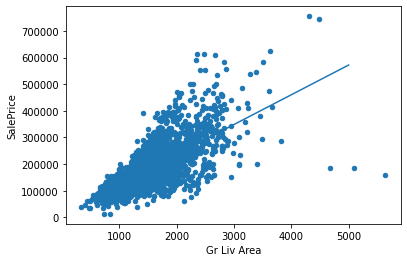

In [ ]:
X_new = pd.DataFrame()
X_new["Gr Liv Area"] = np.linspace(500, 5000, num=200)

y_new_ = pd.Series(
    model.predict(X_new), 
    index=X_new["Gr Liv Area"]    
)

df_ames.plot.scatter(x="Gr Liv Area", y="SalePrice")
y_new_.plot.line()

3\.  There is another way to graph a fitted linear regression model: extract the intercept and coefficient and draw a line with that intercept and slope. Verify that this gives the same graph as Exercise 2.

In [ ]:
model.coef_

array([111.69400086])

In [ ]:
model.intercept_

13289.63436475955

No handles with labels found to put in legend.


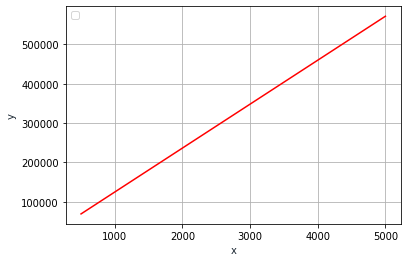

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(500, 5000, 200)
y = 111.69400086*x+13289.63436475955
plt.plot(x, y, '-r')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.grid()
plt.show()


4\. Fit a linear regression model that predicts the price of a home using square footage, number of bedrooms (**Bedroom AbvGr**), number of full bathrooms (**Full Bath**), and number of half bathrooms (**Half Bath**). Interpret the coefficients. Then, use your fitted model to predict the price of a home that is 1500 square feet, with 3 bedrooms, 2 full baths, and 1 half bath.

In [ ]:
ashen_model = LinearRegression()
ashen_model.fit(
    X=df_ames[["Gr Liv Area", "Bedroom AbvGr", "Full Bath", "Half Bath"]],
    y=df_ames["SalePrice"]
)
ashen_model.predict(
    X=df_ames[["Gr Liv Area", "Bedroom AbvGr", "Full Bath", "Half Bath"]])

array([179259.36600924, 119498.42279868, 141911.8475257 , ...,
        98242.85629925, 177721.65791096, 247885.39263788])

In [ ]:
ashen_model.coef_

array([   118.09986838, -29994.95675968,  26728.53342793,   1271.13847733])

The sale price is highest when square footage is high, number of bedrooms is low, and number of full and half baths is high.

In [ ]:
ashen_model.intercept_

46942.32081992371

In [ ]:
1500*118.09986838 + 3*(-29994.95675968) + 2*(26728.53342793) + 1*(1271.13847733) + 46942.32081992371

188835.4584440737

The price of a home that is 1500 square feet, with 3 bedrooms, 2 full baths, and 1 half bath is about $189,000.

_Exercises 5-6 ask you to fit linear regression models to the tips data (http://dlsun.github.io/pods/data/tips.csv ), which contains information about tips collected by a waiter._

In [ ]:
df_tips = pd.read_csv("http://dlsun.github.io/pods/data/tips.csv")
df_tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


5\. Suppose you want to predict how much a male diner will tip on a Sunday bill of \$40.00. Fit a linear regression model to the tips data to answer this question. (Hint: You will need to convert categorical variables to quantitative variables. Refer to Chapter 3.)

In [ ]:
df_tips["day_num"] = df_tips["day"].map({
    "Sun": 1,
    "Mon": 2,
    "Tues": 3,
    "Wed": 4,
    "Thur": 5,
    "Fri": 6,
    "Sat": 7
})

In [ ]:
df_tips["sex_num"] = df_tips["sex"].map({
    "Male": 1,
    "Female": 2
})

In [ ]:
ashen_model = LinearRegression()
ashen_model.fit(
    X=df_tips[["total_bill", "day_num", "sex_num"]],
    y=df_tips["tip"]
)
ashen_model.coef_

array([ 0.10475512, -0.02629637,  0.04062973])

In [ ]:
ashen_model.intercept_

0.9900025749591101

In [ ]:
40*0.10445515 + 1*(-0.02551677) + 1*0.04062973 + 1.0475108406893257

5.240829800689324

A male diner eating a 40 dollar dinner on a Sunday will tip $5.24.

6\. Fit a linear regression model, with no intercept, that predicts the tip from the total bill. That is, we want our predictions to be of the form 
$$ \widehat{\text{tip}} = c \cdot (\text{total bill}). $$
where $c$ is some coefficient to be learned from the training data. 

(_Hint:_ `LinearRegression()` has a parameter, `fit_intercept=`, which is `True` by default.)
    
Plot the data and the fitted model. In practical terms, what assumption is being made when we fit a model with no intercept? 

In [ ]:
X_tips = df_tips[["total_bill"]]
y_tips = df_tips["tip"]

model = LinearRegression(fit_intercept=False)
model.fit(X=X_tips, y=y_tips)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

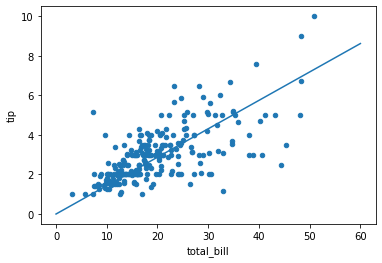

In [ ]:
X_new = pd.DataFrame()
X_new["total_bill"] = np.linspace(0, 60, num=200)

y_new_ = pd.Series(
    model.predict(X_new), 
    index=X_new["total_bill"]    
)

df_tips.plot.scatter(x="total_bill", y="tip")
y_new_.plot.line()

When we fit a model with no intercept, we are saying that none of the features will have a value of 0.